In [ ]:
!pip install rdkit
!pip install smilespe
!pip install selfies
!git clone https://github.com/molecularsets/moses.git
!pip install jax

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 42.4 MB/s eta 0:00:00
Cloning into 'moses'...
remote: Enumerating objects: 1957, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 1957 (delta 0), reused 2 (delta 0), pack-reused 1953
Receiving objects: 100% (1957/1957), 164.05 MiB | 30.72 MiB/s, done.
Resolving deltas: 100% (1068/1068), done.
Filtering content: 100% (68/68), 323.72 MiB | 55.54 MiB/s, done.


In [ ]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import Descriptors
import matplotlib.pyplot as plt
import numpy as np
from collections import OrderedDict
import tensorflow as tf
from itertools import chain
from sklearn.model_selection import train_test_split
import selfies as sf

from keras.models import Sequential, load_model
from sklearn.preprocessing import StandardScaler

In [ ]:
# Load in the Moses dataset containing 1.9 million SMILES strings from cloned
# git repository

df = pd.read_csv("dataset_v1.csv", engine='python')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1936962 entries, 0 to 1936961
Data columns (total 2 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   SMILES  object
 1   SPLIT   object
dtypes: object(2)
memory usage: 29.6+ MB


In [ ]:
# Preprocess Data

# Remove rows with null SMILES
df = df.dropna(subset=['SMILES']) # None

# Remove rows with duplicate SMILES
df = df.drop_duplicates(subset=['SMILES']) # None

smi_dataset = df['SMILES'].values

# Only consider SMILES strings with lengths 50 or below
drops = []
for i in range(len(smi_dataset)):
  if (len(smi_dataset[i]) > 50):
    drops.append(i)
smi_dataset = np.delete(smi_dataset, drops)

In [ ]:
# Train-test split
smi_sub, rest = train_test_split(smi_dataset, test_size = 0.7)
smi_train, smi_test = train_test_split(smi_sub, test_size = 0.2)
print(len(smi_train))

464743


In [ ]:
# Convert SMILES strings in dataset to SELFIES

selfies_train = []
for i in range(len(smi_train)):
  selfies = sf.encoder(smi_train[i])
  selfies_train.append(selfies)

selfies_test = []
for i in range(len(smi_test)):
  selfies = sf.encoder(smi_test[i])
  selfies_test.append(selfies)

np.save('selfies_train.npy', selfies_train)
np.save('selfies_test.npy', selfies_test)

In [ ]:
selfies_train = np.load('selfies_train.npy')
selfies_test = np.load('selfies_test.npy')

In [ ]:
print(len(selfies_test))

116186


In [ ]:
# Tokenize each selfies string in the training set
from SmilesPE.pretokenizer import atomwise_tokenizer

train_tokens = []
for i in range(len(selfies_train)):
  train_tokens.append(atomwise_tokenizer(selfies_train[i]))

test_tokens = []
for i in range(len(selfies_test)):
  test_tokens.append(atomwise_tokenizer(selfies_test[i]))

total_tokens = train_tokens + test_tokens

# Create a list of unique tokens from total tokens
total_tokens += 'E' # Add ending token (indicates end of SELFIES string)
total_tokens += '!' # Add starting token (indicates start of SELFIES string)
unique_chars = sorted(list(OrderedDict.fromkeys(chain.from_iterable(total_tokens))))
print(len(unique_chars))
print(unique_chars)

28
['!', 'E', '[#Branch1]', '[#Branch2]', '[#C]', '[#N]', '[=Branch1]', '[=Branch2]', '[=C]', '[=N]', '[=O]', '[=Ring1]', '[=Ring2]', '[=S]', '[Br]', '[Branch1]', '[Branch2]', '[C]', '[Cl]', '[F]', '[H]', '[NH1]', '[N]', '[O]', '[P]', '[Ring1]', '[Ring2]', '[S]']


In [ ]:
# Create dictionaries mapping tokens to integers for one-hot encoding

char_to_int = dict((c,i) for i,c in enumerate(unique_chars))
int_to_char = dict((i,c) for i,c in enumerate(unique_chars))

In [ ]:
# Find the longest tokenized SELFIES string

embed = len(max(total_tokens, key=len))
print(embed)

51


In [ ]:
# Mean and standard deviation of length of tokenized SMILES strings

lens = []
for i in range(len(total_tokens)):
  lens.append(len(total_tokens[i]))

mean = np.mean(lens)
std = np.std(lens)

print("Mean is " + str(mean))
print("Std dev is " + str(std))

Mean is 34.572952725883106
Std dev is 4.707185310486039


In [ ]:
# Encoder to generate one-hot encodings from a SELFIES string

def encoder(toks, samples, maxlen = embed + 2):
  x = np.zeros((samples, maxlen, len(unique_chars)), dtype=np.int8)
  for i, selfies in enumerate(toks):
    # encode the starting character
    x[i,0,char_to_int["!"]] = 1
    for j,k in enumerate(selfies):
      x[i,j+1,char_to_int[k]] = 1
    x[i,len(selfies)+1:,char_to_int['E']] = 1
  return x[:,0:-1,:], x[:,1:,:]

In [ ]:
# Create the x and y vectors for input into model
x_train, y_train = encoder(train_tokens, len(selfies_train))
x_test, y_test = encoder(test_tokens, len(selfies_test))

In [ ]:
# Create the model
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM

from keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks_list = [
    ModelCheckpoint(
        filepath=f"generative_model_selfies_128.h5",
        monitor="loss",
        save_best_only=True,
    )
  ]

# Search the following hyperparameters
#lr = [0.01, 0.001, 0.0001]
#batch_size = [512, 256, 128]
#dropout = [0.1, 0.25, 0.4]

model = Sequential()
model.add(LSTM(256, input_shape=(None, np.shape(x_train)[2]), return_sequences = True))
model.add(Dropout(0.25))
model.add(LSTM(256, return_sequences = True))
model.add(Dropout(0.25))
model.add(Dense(np.shape(y_train)[-1], activation='softmax'))
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 256)         291840    
                                                                 
 dropout (Dropout)           (None, None, 256)         0         
                                                                 
 lstm_1 (LSTM)               (None, None, 256)         525312    
                                                                 
 dropout_1 (Dropout)         (None, None, 256)         0         
                                                                 
 dense (Dense)               (None, None, 28)          7196      
                                                                 
Total params: 824348 (3.14 MB)
Trainable params: 824348 (3.14 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [ ]:
# Train the data
opt = tf.keras.optimizers.Adam(learning_rate = 0.01)
model.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics=['accuracy'])
history = model.fit(x_train,y_train,epochs = 10, batch_size = 128, callbacks=callbacks_list)

Epoch 1/10
3631/3631 [==============================] - 70s 15ms/step - loss: 0.6438 - accuracy: 0.7823
Epoch 2/10
   4/3631 [..............................] - ETA: 1:01 - loss: 0.4914 - accuracy: 0.8250

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3631/3631 [==============================] - 57s 16ms/step - loss: 0.4788 - accuracy: 0.8285
Epoch 3/10
3631/3631 [==============================] - 60s 17ms/step - loss: 0.4592 - accuracy: 0.8350
Epoch 4/10
3631/3631 [==============================] - 53s 15ms/step - loss: 0.4490 - accuracy: 0.8383
Epoch 5/10
3631/3631 [==============================] - 53s 15ms/step - loss: 0.4425 - accuracy: 0.8405
Epoch 6/10
3631/3631 [==============================] - 57s 16ms/step - loss: 0.4380 - accuracy: 0.8420
Epoch 7/10
3631/3631 [==============================] - 50s 14ms/step - loss: 0.4338 - accuracy: 0.8433
Epoch 8/10
3631/3631 [==============================] - 52s 14ms/step - loss: 0.4309 - accuracy: 0.8443
Epoch 9/10
3631/3631 [==============================] - 50s 14ms/step - loss: 0.4279 - accuracy: 0.8453
Epoch 10/10
3631/3631 [==============================] - 50s 14ms/step - loss: 0.4260 - accuracy: 0.8459


In [ ]:
print(model.evaluate(x_test, y_test))

3631/3631 [==============================] - 26s 7ms/step - loss: 0.4043 - accuracy: 0.8523
[0.4043383300304413, 0.8522534966468811]


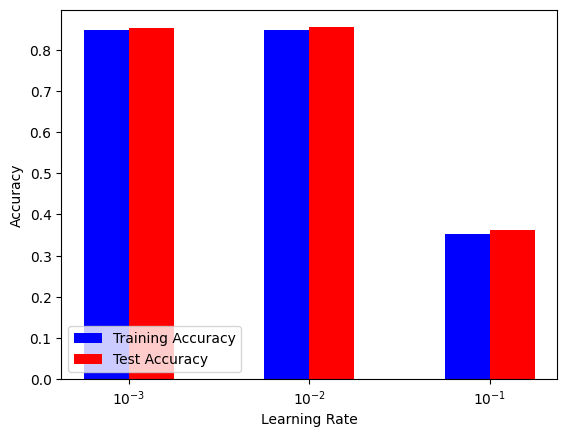

In [ ]:
# Learning rate
lr = np.log10([0.001, 0.01, 0.1])
train_accuracy = [0.8470, 0.8491, 0.3536]
val_accuracy = [0.8533, 0.8549, 0.3621]

bs = [512, 256, 128]
bs_train_accuracy = [0.8428, 0.8491, 0.8403]
bs_val_accuracy = [0.8498, 0.8549, 0.8523]

dropout = [0.1, 0.25, 0.4]
dropout_train_accuracy = [0.8511, 0.8491, 0.8431]
dropout_val_accuracy = [0.8547, 0.8549, 0.8517]

# val accuracy greater than train accuracy possibly because model is underfit -
# would need an even bigger training set. Also b/c small number of epochs
plt.bar([1,2,3], train_accuracy, width = -0.25, align = 'edge', color = 'blue', label = 'Training Accuracy')
plt.bar([1,2,3], val_accuracy, width = 0.25, align = 'edge', color = 'red', label = 'Test Accuracy')
plt.ylabel('Accuracy')
plt.xticks([1,2,3], ['$10^{-3}$', '$10^{-2}$', '$10^{-1}$'])
plt.xlabel('Learning Rate')
plt.legend(loc = 'lower left')
plt.show()

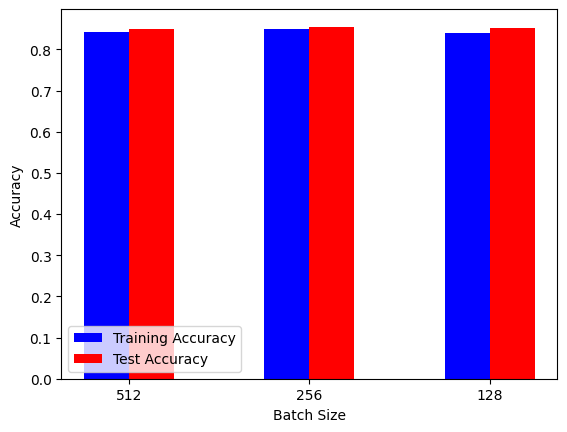

In [ ]:
plt.bar([1,2,3], bs_train_accuracy, width = -0.25, align = 'edge', color = 'blue', label = 'Training Accuracy')
plt.bar([1,2,3], bs_val_accuracy, width = 0.25, align = 'edge', color = 'red', label = 'Test Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Batch Size')
plt.xticks([1,2,3], ['512', '256', '128'])
plt.legend(loc='lower left')
plt.show()

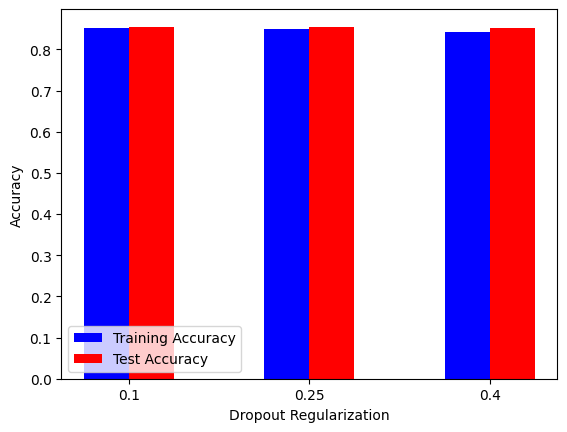

In [ ]:
plt.bar([1,2,3], dropout_train_accuracy, width = -0.25, align = 'edge', color = 'blue', label = 'Training Accuracy')
plt.bar([1,2,3], dropout_val_accuracy, width = 0.25, align = 'edge', color = 'red', label = 'Test Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Dropout Regularization')
plt.xticks([1,2,3], ['0.1', '0.25', '0.4'])
plt.legend(loc='lower left')
plt.show()

In [ ]:
# Generate molecules from an initial character
from keras.models import load_model

model = load_model('generative_model_selfies_best.h5')

def generate_mol(model, start_smi):
  # Probability array
  prob_array = []

  # Encode the start character
  smi_tokens = [start_smi]
  char_vec = np.zeros((1,len(smi_tokens),len(unique_chars)))
  for i in range(len(smi_tokens)):
    char_vec[0,i,char_to_int[smi_tokens[i]]] = 1
  smi_string = start_smi

  # Predict the first character
  predict = model.predict(char_vec, verbose=0).flatten() # Generates probabilities of next char
  next_char = int_to_char[np.random.choice(np.arange(0,len(char_to_int)), p=predict)]
  prob_array.append(predict)
  smi_string += next_char # append the generated character to the SMILES string
  next_char_encoded = np.zeros((1,1,len(unique_chars)))
  next_char_encoded[0,0,char_to_int[next_char]] = 1 # Encode the predicted char
  char_vec = np.append(char_vec, next_char_encoded, axis=1) # Append it to starting char


  # Repeat the above prediction tasks until we hit the ending token 'E'
  while next_char != 'E':
    prediction = model.predict(np.expand_dims(char_vec[:,-1,:], axis = 1), verbose=0).flatten()
    #next_char = int_to_char[np.argmax(prediction)]
    next_char = int_to_char[np.random.choice(np.arange(0,len(char_to_int)), size=None, replace=True, p=prediction)]
    prob_array.append(prediction)

    next_char_encoded = np.zeros((1,1,len(unique_chars)))
    next_char_encoded[0,0,char_to_int[next_char]] = 1
    char_vec = np.append(char_vec, next_char_encoded, axis=1)
    smi_string += next_char

  return smi_string, prob_array

In [ ]:
first_tokens = []

for i in range(len(selfies_train)):
  first_tokens.append(selfies_train[i][:3])

unique_tokens = []
for i in range(len(first_tokens)):
  if first_tokens[i] not in unique_tokens:
    unique_tokens.append(first_tokens[i])

unique_tokens = ['[O]', '[C]', '[N]', '[F]', '[Br', '[Cl', '[H]']

NameError: ignored

In [ ]:
first_token_counts = np.zeros((7))
for i in range(len(first_tokens)):
  for j in range(len(unique_tokens)):
    if unique_tokens[j] == first_tokens[i]:
      first_token_counts[j] += 1
    else:
      continue

first_token_probs = first_token_counts / len(selfies_train)
unq_tokens = ['[O]', '[C]', '[N]', '[F]', '[Br]', '[Cl]', '[H]']
print(first_token_probs)
first_token_probs = [1.35408172e-01, 8.07809908e-01, 4.94337731e-02, 4.92745453e-03, 8.39173479e-04, 1.46102254e-03, 1.20496705e-04]

[1.35408172e-01 8.07809908e-01 4.94337731e-02 4.92745453e-03
 8.39173479e-04 1.46102254e-03 1.20496705e-04]


In [ ]:
unique_chars = ['!', 'E', '[#Branch1]', '[#Branch2]', '[#C]', '[#N]', '[=Branch1]', '[=Branch2]', '[=C]', '[=N]', '[=O]', '[=Ring1]', '[=Ring2]', '[=S]', '[Br]', '[Branch1]', '[Branch2]', '[C]', '[Cl]', '[F]', '[H]', '[NH1]', '[N]', '[O]', '[P]', '[Ring1]', '[Ring2]', '[S]']

char_to_int = dict((c,i) for i,c in enumerate(unique_chars))
int_to_char = dict((i,c) for i,c in enumerate(unique_chars))

In [ ]:
print(len(unique_chars))

28


In [ ]:
print(selfies_train[28])

[C][C][=C][C][Branch1][C][C][=C][Branch1][S][C][N][C][=Branch1][C][=O][C][=C][C][=C][C][=C][Ring1][=Branch1][C][C][=Branch1][C][=O][NH1][Ring2][Ring1][Ring1]


In [ ]:
generated_self = np.load('generated_self_np.npy')

In [ ]:
# Generate molecules from a starting token
first_token_probs = [1.35408172e-01, 8.07809908e-01, 4.94337731e-02, 4.92745453e-03, 8.39173479e-04, 1.46102254e-03, 1.20496705e-04]
unq_tokens = ['[O]', '[C]', '[N]', '[F]', '[Br]', '[Cl]', '[H]']

generated_self = []
probabilities = []
for i in range(1000):
  starting_char_num = np.random.choice(np.arange(0,len(unq_tokens)), p = first_token_probs)
  starting_char = unq_tokens[starting_char_num]
  selfies, prob = generate_mol(model, starting_char)
  generated_self.append(selfies)
  probabilities.append(prob)

generated_self_np = np.array(generated_self)
np.save('generated_self_np.npy', generated_self_np)

In [ ]:
def remove_e(self_array):
  clean_self = []
  for selfies in self_array:
    selfies_clean = selfies[:-1]
    clean_self.append(selfies_clean)
  clean_self = [s.replace('!', '') for s in clean_self]
  return clean_self

In [ ]:
generated_self_clean = remove_e(generated_self)
print(generated_self_clean)

['[N][=C][N][=C][S][=Branch1][C][C][C][O][=C][S][C][C][C][C][C][C][=C][N][N][=C][C][C][N][C][C][C][C][C][C][C][C][C][C][C][O][=C][N]', '[C][=C][C][C][C][C][C][O]', '[C][N][#Branch1][C][C][O][=C][C][O][=C][C][C][C][C][C][O][=C][C][O][=C][S][=Branch1][C][O][=C][C][O][=C][C][C][C][S][=Branch1][C][C][C][N]', '[C][N][=C][C][C][C][C][C][C][N][=C][Branch1][C][N][Ring2][Ring1][#Branch1][C][C][C][C][C][C][O][=C][NH1][C][N][=N][C][C][C][C][C][C][O][=C][N][=C][S][=Branch1][C][C][C][N]', '[C][C][C][N][Ring2][Ring1][S][=Branch1][C][N][=C][Ring1][=Branch1][C][C][N][=C][C][C][C][C][C][C][C][C][C][N][C][C][S][=Branch1][C][C][C][C][N][=N][N][Ring2][Ring1][#Branch1][C][C][O][=C][C][C][C][O]', '[C][C][C][C][C][C][C][C][N][Branch1][C][C][C][C][C][C][=C][C][C][C][O][=C][Branch1][C][O][=C][O]', '[C][=C][Ring1][#Branch1][C][C][N][Ring1][=C][C][C][C][C][C][C][=C][S][Ring1][S][C][O][=C][O][=C][C][N][NH1][C][Ring1][=Branch1][C][=N][C][N]', '[C][C][C][C][C][C][O][=C][N][=C][C][C][S][=Branch1][C][=C][C][O]', '[C]

In [ ]:
# Count the number of syntactically valid and chemically reasonable generated SMILES

valid_count = 0
invalid_count = 0
valid_smi = []
for smi in generated_self_clean:
  smi_from_selfie = sf.decoder(smi)
  m = Chem.MolFromSmiles(smi_from_selfie, sanitize=True)
  if m is None:
    invalid_count += 1
  else:
    valid_smi.append(smi_from_selfie)
    valid_count += 1

valid_smi_ratio = valid_count / (valid_count + invalid_count)

In [ ]:
print(valid_smi_ratio)

1.0


In [ ]:
# Percentage of generated molecules found in training set
same_train = 0

for smi in valid_smi:
  if (sf.encoder(smi) in selfies_train):
    same_train += 1

train_ratio = same_train / len(generated_self_clean)
print(train_ratio)

0.0


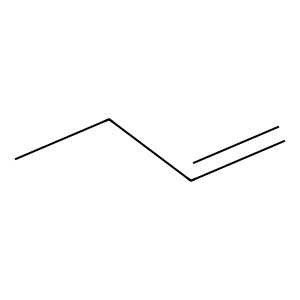

In [ ]:
m = Chem.MolFromSmiles(valid_smi[987], sanitize=True)
Draw.MolToImage(m)